In [77]:
import math
import os
import pandas as pd
import csv

def parse_file(f):
    tasks = []
    with open(f) as f_in:
        while (line := f_in.readline()):
            line = line.strip()
            if line.startswith('TASK'):
                _, type, task, ts = line.split(' ')
                ts = float(ts)
                if type == 'START:':
                    tasks.append([int(task), 'start', ts])
                else:
                    tasks.append([int(task), 'end', ts])
    return tasks


def parse_pool_file(f, pool, timings):
    tasks = {}
    with open(f) as f_in:
        while (line := f_in.readline()):
            line = line.strip()
            if line.startswith('TASK'):
                _, type, task, ts = line.split(' ')
                ts = float(ts)
                if type == 'START:':
                    tasks[int(task)] = [ts]
                else:
                    tasks[int(task)].append(ts)

    for task_id, tss in tasks.items():
        start, end = tss
        timings['task_id'].append(task_id)
        timings['task_id'].append(task_id)

        timings['timing_type'].append('start')
        timings['timestamp'].append(start)

        timings['timing_type'].append('end')
        timings['timestamp'].append(end)

        timings['task_type'].append(pool)
        timings['task_type'].append(pool)

        timings['duration'].append(end - start)
        timings['duration'].append(end - start)


def parse_reprio_file(f, timings, priority_updates):
    with open(f) as f_in:
        while (line := f_in.readline()):
            line = line.strip()
            if line.startswith('R'):
                _, type, ts = line.split(' ')
                ts = float(ts)
                if type == 'START:':
                    timings['task_id'].append(-1)
                    timings['task_type'].append('reprio')
                    timings['timing_type'].append('start')
                    timings['timestamp'].append(ts)
                else:
                    timings['task_id'].append(-1)
                    timings['task_type'].append('reprio')
                    timings['timing_type'].append('end')
                    start = timings['timestamp'][-1]
                    timings['timestamp'].append(ts)
                    
                    timings['duration'].append(ts - start)
                    timings['duration'].append(ts - start)
            elif line.startswith('P UPDATE:'):
                _, _, task_id, old_p, new_p = line.split(' ')
                priority_updates.append([int(task_id), int(old_p), int(new_p)])

def parse_run(root):
    pools = ['bebop1', 'bebop2', 'bebop3']
    fs = os.listdir(root)
    timings = {'task_id': [], 'timestamp': [], 'timing_type': [], 'task_type': [], 'duration': []}
    priority_updates = []
    for f in fs:
        ff = os.path.join(root, f)
        if os.path.isdir(ff):
            for p in pools:
                if f.find(p) != -1:
                    pool = p
                    break
            output = os.path.join(ff, 'output.txt')
            parse_pool_file(output, pool, timings)
        elif f.find('_output.txt') != -1:
            parse_reprio_file(ff, timings, priority_updates)
    
    timings = pd.DataFrame.from_dict(timings)
    return timings, priority_updates


roots = ['/home/nick/Documents/data/parsocial_paper_runs/bs_33_th1', '/home/nick/Documents/data/parsocial_paper_runs/bs_33_th15',
         '/home/nick/Documents/data/parsocial_paper_runs/bs_50_th1']
for r in roots:
    timings, priority_updates = parse_run(r)
    timings.to_csv(os.path.join(r, 'raw_timings.csv'), index=False)

    priorities_f = os.path.join(r, 'priority_updates.csv')
    with open(priorities_f, 'w') as fout:
        writer = csv.writer(fout)
        writer.writerow(['task_id', 'priority_1', 'priority_2'])
        writer.writerows(priority_updates)

    min_ts = timings.timestamp.min()
    timings['delta_ts'] = timings.timestamp - min_ts
    timings['task_count'] = 0
    timings['total_task_count'] = 0

    dfs = []
    for pool_name in ['bebop1', 'bebop2', 'bebop3']:
        pool = timings[timings.task_type == pool_name]
        sorted_pool = pool.sort_values('timestamp')
        sorted_pool.reset_index(drop=True, inplace=True)
        sorted_pool.loc[0, 'task_count'] = 1
        for i in range(1, len(sorted_pool)):
            count = sorted_pool.loc[i - 1, 'task_count']
            sorted_pool.loc[i, 'task_count'] = count + 1 if sorted_pool.loc[i, 'timing_type'] == 'start' else count - 1
        dfs.append(sorted_pool)

    df_counts = pd.concat(dfs)
    df_counts = df_counts.sort_values('timestamp')
    df_counts.reset_index(drop=True, inplace=True)
    df_counts['total_task_count'] = 0
    df_counts.loc[0, 'total_task_count'] = 1

    for i in range(1, len(df_counts)):
        count = df_counts.loc[i - 1, 'total_task_count']
        df_counts.loc[i, 'total_task_count'] = count + 1 if df_counts.loc[i, 'timing_type'] == 'start' else count - 1

    pd.concat([df_counts, timings[timings.task_id == -1]]).to_csv(os.path.join(r, 'task_counts.csv'), index=False)

    

    


In [97]:
df_counts = pd.read_csv('/home/nick/Documents/data/parsocial_paper_runs/bs_33_th1/task_counts.csv')
df_counts = df_counts[df_counts.task_type.str.startswith('bebop') ]
df_counts = df_counts.sort_values('timestamp')
df_counts.reset_index(drop=True, inplace=True)
df_counts['total_task_count'] = 0
df_counts.loc[0, 'total_task_count'] = 1

for i in range(1, len(df_counts)):
    count = df_counts.loc[i - 1, 'total_task_count']
    df_counts.loc[i, 'total_task_count'] = count + 1 if df_counts.loc[i, 'timing_type'] == 'start' else count - 1

# df_counts[(df_counts.delta_ts > 58) & (df_counts.delta_ts < 62)].head(n=40)
df_counts

# bebop1 = df_counts[df_counts.task_type == 'bebop1']
# bebop2 = df_counts[df_counts.task_type == 'bebop2']

# bebop2.head(n=40)
    





,task_id,timestamp,timing_type,task_type,duration,delta_ts,task_count,total_task_count
0,30,1.675787e+09,start,bebop1,100.513983,0.000000,1,1
1,8,1.675787e+09,start,bebop1,11.476034,0.030552,2,2
2,13,1.675787e+09,start,bebop1,5.384546,0.034627,3,3
3,22,1.675787e+09,start,bebop1,8.226239,0.039651,4,4
4,17,1.675787e+09,start,bebop1,28.802775,0.045599,5,5
...,...,...,...,...,...,...,...,...
1495,132,1.675787e+09,end,bebop2,78.807017,196.864981,1,4
1496,131,1.675787e+09,end,bebop3,79.396816,198.004604,0,3
1497,399,1.675787e+09,end,bebop1,148.479217,221.438305,1,2
1498,197,1.675787e+09,end,bebop2,100.265289,224.801662,0,1


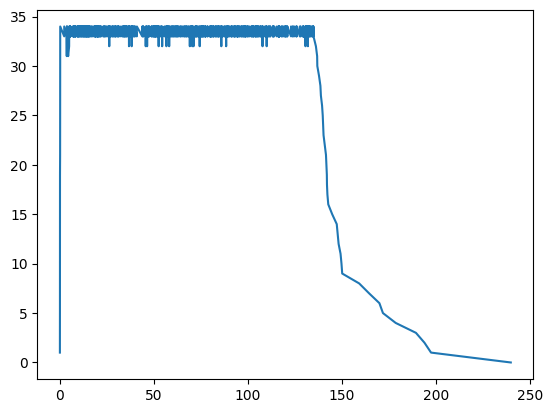

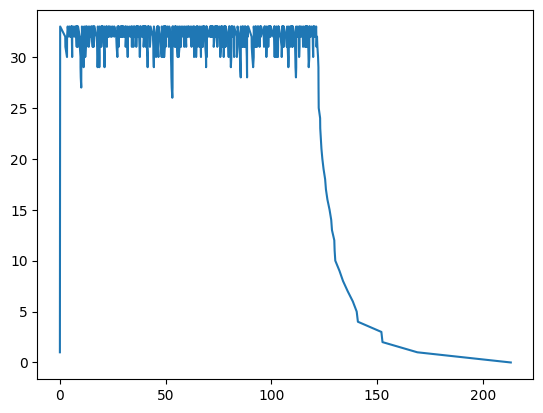

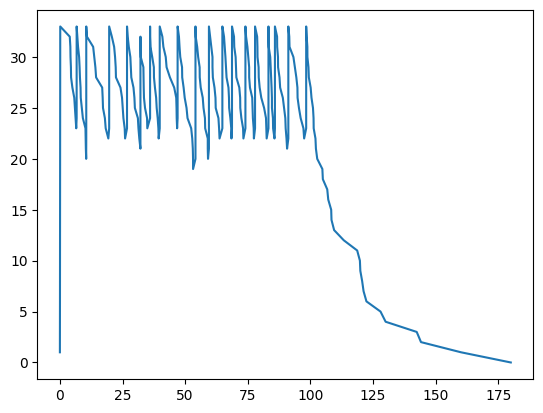

In [19]:
import matplotlib.pyplot as plt

# 750_threshold_1-bebop1_1675717614.148026
fs = ['./test_data/bebop1_threshold_1_batch_40.txt', './test_data/bebop1_threshold_1.txt', './test_data/bebop1_threashold_10.txt']
for f in fs:
    tasks = parse_file(f)
    tasks = sorted(tasks, key=lambda x: x[2])

    x = [0.0]
    y = [1]

    t1 = tasks[0][2]
    count = 1
    for task in tasks[1:]:
        if task[1] == 'start':
            count += 1
        else:
            count -=1
        y.append(count)
        x.append(task[2] - t1)

    

    # plt.plot(x, y)
    # plt.show()
    


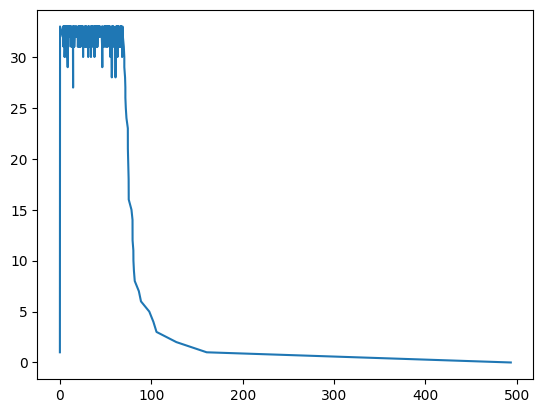

In [12]:
import matplotlib.pyplot as plt
plt.plot(x, y)
plt.show()